## CNN USING EEG DATA WITH COH feature ##

- In this notebook you will be able to see custom CNN model for EEG Data. Data consists of the 19 electrodes with signals of 6 frequency bands -- alpha, beta, etc. and their coherence with each other

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np

#importing final dataset prepared for training after ETA and EDA to prepare a CNN based classification model.

df = pd.read_csv('./data/final_dataset_train_all.csv')
df.head()

,delta.FP1,delta.FP2,delta.F7,delta.F3,delta.Fz,delta.F4,delta.F8,delta.T3,delta.C3,delta.Cz,...,COH.gamma.Pz.T6,COH.gamma.Pz.O1,COH.gamma.Pz.O2,COH.gamma.P4.T6,COH.gamma.P4.O1,COH.gamma.P4.O2,COH.gamma.T6.O1,COH.gamma.T6.O2,COH.gamma.O1.O2,main.disorder
0,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,9.975238,14.834740,10.950564,...,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261,Addictive disorder
1,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,12.775574,21.686306,18.367666,...,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799,Addictive disorder
2,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,8.063191,11.015078,11.639560,...,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873,Addictive disorder
3,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,9.434306,15.244523,17.041979,...,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662,Addictive disorder
4,13.482096,14.095855,12.854630,11.727480,13.128924,11.627138,14.978119,6.899770,9.751346,14.141171,...,82.302355,83.938567,88.213886,90.972026,77.443894,89.545596,72.579530,89.462863,86.127823,Addictive disorder


- We have total of 1141 columns in this dataset including our target `main.disorder`
- Thus, we will use 1140 features to predict the main-disorder of a person

## Preparing Train-Valid Data
- Since we already have prepared the train and test data ahead to prevent the data leakage, now we will separate the train data into train-valid data.
#### ONE HOT ENCODING FOR TARGETS ####
- Since we have seven classes including healthy control we encoded the `target - main.disorder` with the one hot encoding.
- This makes our y_data into shape of nx7

In [2]:
target = 'main.disorder'

y = df[target].copy()
y.shape

(1792,)

In [3]:
Y = pd.get_dummies(y)
Y.shape

(1792, 7)

In [4]:
Y.head()

,Addictive disorder,Anxiety disorder,Healthy control,Mood disorder,Obsessive compulsive disorder,Schizophrenia,Trauma and stress related disorder
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [5]:
X = df.drop([target], axis = 1)
X.shape

(1792, 1140)

In [6]:
from sklearn.model_selection import train_test_split
def train_test_dataset(X,y, split):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_dataset(X,Y, split = 0.10)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1612, 1140), (180, 1140), (1612, 7), (180, 7))

### This is the shape of our final train and valid data ###

- Below this cell we tried to make sure that all the classes are included in our train and valid dataset

In [7]:
# Make sure that in 10% split we will have all the classes in valid and train set.

assert len(y_test.sum(axis=0)) == len(y_train.sum(axis=0))
y_test.sum(axis=0), y_train.sum(axis=0)

(Addictive disorder                    25
 Anxiety disorder                      23
 Healthy control                       19
 Mood disorder                         34
 Obsessive compulsive disorder         28
 Schizophrenia                         26
 Trauma and stress related disorder    25
 dtype: int64,
 Addictive disorder                    231
 Anxiety disorder                      233
 Healthy control                       237
 Mood disorder                         222
 Obsessive compulsive disorder         228
 Schizophrenia                         230
 Trauma and stress related disorder    231
 dtype: int64)

## USING MINMAX NORMALIZATION FOR THE SIGNAL DATA ##

$$ m = \frac{(x -xmin)}{(xmax -xmin)} $$

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X.columns)

### Prepare custom dataset to load the data in dataloader for pytorch approarch ###

In [9]:
#Prepare manual dataset that will return target and features to our model
torch.manual_seed(555)
datasets = {}
class EEGDataset(Dataset):
    def __init__(self, X,y):
        self.X = torch.tensor(X.values)
        self.y = torch.tensor(y.values)

    def __getitem__(self, idx):
        preds = self.X[idx].float()
        trgts = self.y[idx].float()
        
        return preds, trgts

    def __len__(self):
        return len(self.X)

datasets['train'] = EEGDataset(X_train,y_train)
datasets['test'] = EEGDataset(X_test,y_test)

In [10]:
datasets['train'][0], datasets['test'][0]

((tensor([0.2259, 0.2559, 0.3242,  ..., 0.2722, 0.6009, 0.4339]),
  tensor([0., 1., 0., 0., 0., 0., 0.])),
 (tensor([0.0978, 0.1014, 0.0635,  ..., 0.3474, 0.7995, 0.5170]),
  tensor([0., 0., 0., 1., 0., 0., 0.])))

In [11]:
train_loader = DataLoader(datasets['train'], shuffle=True)
test_loader = DataLoader(datasets['test'],shuffle=True)

In [12]:
for X, y in train_loader:
    print(X)
    print(y)
    break

tensor([[0.0635, 0.0981, 0.0942,  ..., 0.0854, 0.4309, 0.5808]])
tensor([[0., 0., 0., 0., 0., 0., 1.]])


In [13]:
print("Number of training samples: ",len(datasets['train']))
print("Number of testing samples: ",len(datasets['test']))

Number of training samples:  1612
Number of testing samples:  180


In [14]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [15]:
class eegConv1d(nn.Module):
    def __init__(self, input_size = 1, hidden_size=32, out_size=7):
        super().__init__()
        self.conv1d   = nn.Conv1d(input_size, hidden_size, kernel_size = 3,stride =1)
        # nn.init.normal_(self.conv1d.weight, mean=0.0, std=1)
        self.linear = nn.Linear(36416, out_size) 
        
    def forward(self, seq):
        #seq = seq.unsqueeze(dim=0)
        out = self.conv1d(seq) 
        out = out.reshape(-1,36416)
        out = self.linear(out)
        return out  

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1,64,6,stride = 1)
        # nn.init.normal_(self.conv1.weight, mean=0.0, std=1)
        self.conv2 = nn.Conv1d(64,8,6,stride = 1)
        # nn.init.normal_(self.conv2.weight, mean=0.0, std=1)
        self.linear1 = nn.Linear(9040,1024) #
        self.linear2 = nn.Linear(1024, 7)
        self.leakyrelu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p = 0.25)
        
        #self.softmax = nn.Softmax()
    def forward(self, X):
        #X = X.unsqueeze(dim=0)
        X = self.leakyrelu(self.conv1(X))
        X = self.leakyrelu(self.conv2(X)) 
#         X = self.dropout(X)
#         X = self.dropout(X)
        X = X.view(-1, 9040)
        X = self.leakyrelu(self.linear1(X))
        X = self.dropout(X)
        X = self.leakyrelu(self.linear2(X))

        return X

In [17]:
device = torch.device('cuda:2')
CNNmodel_s  = eegConv1d().to(device)
print("Small Model parameters")
count_parameters(CNNmodel_s)

Small Model parameters
    96
    32
254912
     7
______
255047


In [18]:
CNNmodel_l  = CNN().to(device)
print("Large Model parameters")
count_parameters(CNNmodel_l)

Large Model parameters
   384
    64
  3072
     8
9256960
  1024
  7168
     7
______
9268687


## SELECT FROM THE ABOVE MODELs FOR TRAINING ##

In [19]:
print("Please select from above models... 0 for simple model, 1 for deep model")
mod = int(input())
if mod == 0:
    CNNmodel = CNNmodel_s
    mo = "Simple"
elif mod == 1:
    CNNmodel = CNNmodel_l
    mo = "Deep"


Please select from above models... 0 for simple model, 1 for deep model


 1


In [20]:
CNNmodel

CNN(
  (conv1): Conv1d(1, 64, kernel_size=(6,), stride=(1,))
  (conv2): Conv1d(64, 8, kernel_size=(6,), stride=(1,))
  (linear1): Linear(in_features=9040, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=7, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.25, inplace=False)
)

### SELECT OPTIMIZER, LEARNING RATES AND OTHER HYPERPARAMS FOR TRAINING ###

In [21]:
criterion = nn.CrossEntropyLoss()
print("Choose optimizer. Enter 0 for Adam and 1 for SGD")
op = input()
if int(op) == 0:
    optim = 'ADAM'
    print("Enter the learning rate")
    learning_rate = float(input())
    optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=learning_rate)
    
elif int(op) == 1:
    optim = 'SGD'
    print("Enter the learning rate")
    learning_rate = float(input())
    print("Enter the momentum value.. (0-1)")
    m = float(input())
    optimizer = torch.optim.SGD(CNNmodel.parameters(), lr=learning_rate, momentum = m)

Choose optimizer. Enter 0 for Adam and 1 for SGD


 0


Enter the learning rate


 0.0005


In [22]:
optimizer, criterion

(Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: False
     lr: 0.0005
     maximize: False
     weight_decay: 0
 ),
 CrossEntropyLoss())

In [23]:
CNNmodel

CNN(
  (conv1): Conv1d(1, 64, kernel_size=(6,), stride=(1,))
  (conv2): Conv1d(64, 8, kernel_size=(6,), stride=(1,))
  (linear1): Linear(in_features=9040, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=7, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.25, inplace=False)
)

## TRAINING AND VALIDATION ##

In [24]:
import time

epochs = 100

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
best_val_loss = 10
early_stoping = False
j=0


for i in range(epochs):
    start_time = time.time()
    confusion_matrix = np.zeros((7,7))
    train_correct = 0
    train_total = 0
    val_total   = 0  
    train_acc   = 0
    val_acc     = 0
    val_correct = 0
    CNNmodel.train()
    for X_train, y_train in train_loader:
        y_train = y_train.to(device)
        X_train = X_train.to(device)
        y_pred = CNNmodel(X_train)
        predicted = torch.max(y_pred, 1)[1]
        train_total += y_train.size(0)
        train_correct += (predicted == torch.argmax(y_train,1)).sum().item()
        train_acc = 100 * (train_correct / train_total)
        train_loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    
    # Run the validation batches
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(test_loader):
            y_val = y_val.to(device)
            X_val = X_val.to(device)
            yhat_val = CNNmodel(X_val)     
            _, predicted = torch.max(yhat_val.data, 1)
            val_total += y_val.size(0)  #keep track of total
            actual = torch.argmax(y_val,1)
            val_correct += (predicted == actual).sum().item()  #.item() give the raw number
            confusion_matrix[predicted][actual] +=1
            val_acc = 100 * (val_correct / val_total)
            val_loss = criterion(yhat_val, y_val)
    val_losses.append(val_loss)
    val_accuracy.append(val_acc)
    end_time = time.time()
    print(f"Epoch {i} train_loss:{train_loss:10.3f} train_acc:{train_acc:10.4f} val_acc: {val_acc:10.3f} val_loss:{val_loss:10.4f}")
     
    if val_loss > best_val_loss:
        j = j+1
        if j==10:
            print(f".................Early stoping....................at Epoch :{i+1}" )
            print(confusion_matrix)
            break
    elif best_val_loss > val_loss:
        j = 0
        best_val_loss = val_loss
        xyz = 'models/with_COH_epoch_' + str(i) + '_model_' + str(mo) +'_' +str(optim) + '.pth.tar'
        torch.save(CNNmodel.state_dict(), xyz)

Epoch 0 train_loss:     1.946 train_acc:   15.5707 val_acc:     11.111 val_loss:    1.9449
Epoch 1 train_loss:     1.954 train_acc:   15.6328 val_acc:     15.556 val_loss:    1.9413
Epoch 2 train_loss:     1.927 train_acc:   15.1985 val_acc:     10.000 val_loss:    1.9545
Epoch 3 train_loss:     2.211 train_acc:   18.6104 val_acc:     16.667 val_loss:    1.8373
Epoch 4 train_loss:     1.564 train_acc:   29.0323 val_acc:     35.000 val_loss:    1.6512
Epoch 5 train_loss:     1.281 train_acc:   40.8809 val_acc:     33.889 val_loss:    2.0383
Epoch 6 train_loss:     1.358 train_acc:   48.8213 val_acc:     47.222 val_loss:    2.4357
Epoch 7 train_loss:     1.212 train_acc:   55.7692 val_acc:     53.889 val_loss:    0.8150
Epoch 8 train_loss:     0.588 train_acc:   65.3226 val_acc:     50.556 val_loss:    2.9733
Epoch 9 train_loss:     0.406 train_acc:   72.4566 val_acc:     62.222 val_loss:    1.0960
Epoch 10 train_loss:     0.323 train_acc:   77.5434 val_acc:     65.000 val_loss:    2.012

In [33]:
train_losses_n = [tensor.item() for tensor in train_losses]
val_losses_n = [tensor for tensor in val_losses]

### VALIDATION AND TRAINING LOSS COMPARISION ###

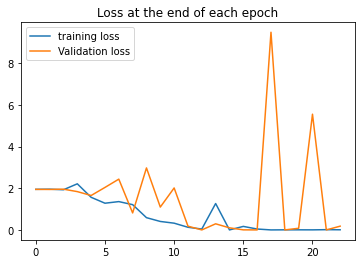

In [38]:
import matplotlib.pyplot as plt
plt.plot(train_losses_n, label='training loss')
plt.plot(val_losses_n, label='Validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();
# plt.ylim(0,2)
plt.savefig(f"Loss_comparision_{optim}_lr_{learning_rate}_model_{mo}.png")

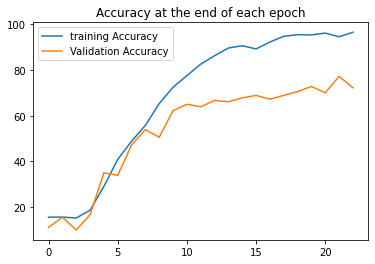

In [39]:
plt.plot(train_accuracy, label='training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();
plt.savefig(f"Accuracy_comparision_{optim}_lr_{learning_rate}_model_{mo}.png")

### Standardize the Confusion Matrix and Display the Matrix ###

In [40]:
final_matrix = confusion_matrix / confusion_matrix.sum(axis = 0)
final_matrix

array([[0.56      , 0.04347826, 0.        , 0.17647059, 0.        ,
        0.        , 0.        ],
       [0.04      , 0.82608696, 0.        , 0.20588235, 0.        ,
        0.        , 0.08      ],
       [0.08      , 0.        , 0.84210526, 0.        , 0.        ,
        0.03846154, 0.        ],
       [0.12      , 0.04347826, 0.        , 0.38235294, 0.        ,
        0.03846154, 0.12      ],
       [0.04      , 0.04347826, 0.        , 0.        , 1.        ,
        0.        , 0.        ],
       [0.16      , 0.04347826, 0.15789474, 0.11764706, 0.        ,
        0.80769231, 0.04      ],
       [0.        , 0.        , 0.        , 0.11764706, 0.        ,
        0.11538462, 0.76      ]])

/tmp/ipykernel_1494/1342201711.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+target_cols)
/tmp/ipykernel_1494/1342201711.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+target_cols, rotation=90)


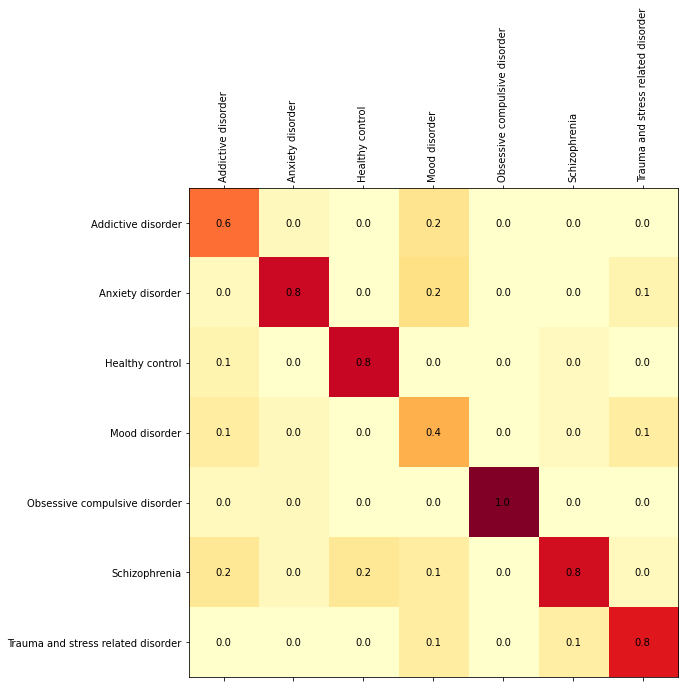

<Figure size 432x288 with 0 Axes>

In [41]:
## SHOW CONFUSION MATRIX

target_cols = Y.columns.tolist()
fig, ax = plt.subplots()
fig.set_figheight(9)
fig.set_figwidth(9)
ax.set_yticklabels(['']+target_cols)
ax.set_xticklabels(['']+target_cols, rotation=90)

# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(final_matrix, cmap='YlOrRd')
for (i, j), z in np.ndenumerate(final_matrix):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()
plt.savefig(f"Confusion_matrix_{optim}_lr_{learning_rate}_model_{mo}.png")

## TESTING ON TEST DATA ##

In [56]:
ttestt = pd.read_csv("final_dataset_test_all.csv")
ttestt.shape

(70, 1141)

In [58]:
target = 'main.disorder'

test_y = ttestt[target].copy()
test_y.shape

(70,)

In [59]:
test_Y = pd.get_dummies(test_y)
test_Y.shape

(70, 7)

In [60]:
test_X = ttestt.drop([target], axis = 1)
test_X.shape

(70, 1140)

In [61]:
datasets['ttestt'] = EEGDataset(test_X,test_Y)
print("Number of testing samples: ",len(datasets['ttestt']))
ttestt_loader = DataLoader(datasets['ttestt'],shuffle=True)

Number of testing samples:  70


In [62]:
test_accuracy = []
test_confusion_matrix = np.zeros((7,7))
test_correct = 0
test_total = 0

CNNmodel.eval()
with torch.no_grad():
    for b, (X_test, y_test) in enumerate(ttestt_loader):
        y_test = y_test.to(device)
        X_test = X_test.to(device)
        yhat_test = CNNmodel(X_test)     
        _, predicted = torch.max(yhat_test.data, 1)
        test_total += y_test.size(0)  #keep track of total
        actual = torch.argmax(y_test,1)
        test_correct += (predicted == actual).sum().item()  #.item() give the raw number
        test_confusion_matrix[predicted][actual] +=1
        test_acc = 100 * (test_correct / test_total)
        # test_loss = criterion(yhat_test, y_test)
# test_losses.append(test_loss)
test_accuracy.append(test_acc)

In [63]:
print(f"Test_Dataset_Accuracy: {test_accuracy[0]}")

Test_Dataset_Accuracy: 21.428571428571427


In [64]:
test_final_matrix = test_confusion_matrix / test_confusion_matrix.sum(axis = 0)
test_final_matrix

array([[0.8, 0.9, 0.5, 0.5, 0.7, 0.5, 0.9],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0. , 0. ],
       [0.1, 0.1, 0.2, 0.2, 0.1, 0.1, 0.1],
       [0.1, 0. , 0. , 0.1, 0.2, 0.2, 0. ],
       [0. , 0. , 0.1, 0.2, 0. , 0.2, 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0. , 0. ]])

/tmp/ipykernel_1494/2827707624.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+target_cols)
/tmp/ipykernel_1494/2827707624.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+target_cols, rotation=90)


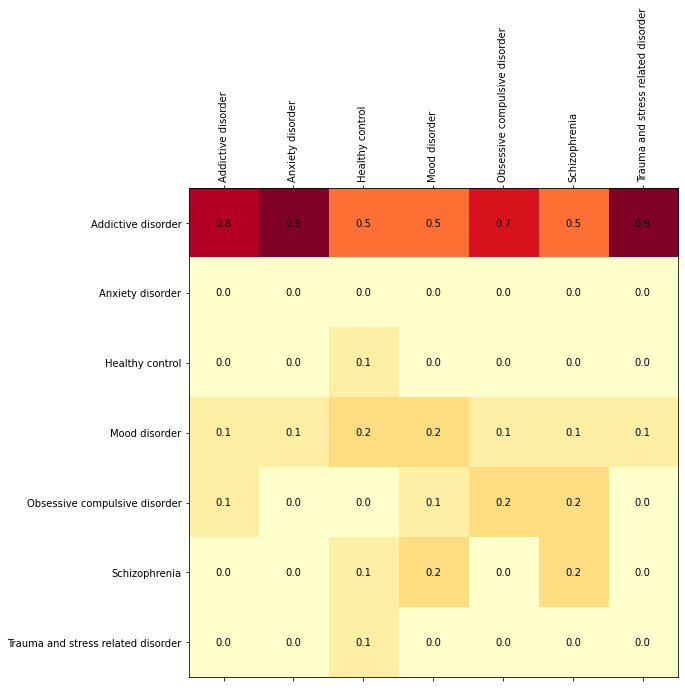

<Figure size 432x288 with 0 Axes>

In [65]:
## SHOW CONFUSION MATRIX

target_cols = Y.columns.tolist()
fig, ax = plt.subplots()
fig.set_figheight(9)
fig.set_figwidth(9)
ax.set_yticklabels(['']+target_cols)
ax.set_xticklabels(['']+target_cols, rotation=90)

# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(test_final_matrix, cmap='YlOrRd')
for (i, j), z in np.ndenumerate(test_final_matrix):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()
plt.savefig(f"Test_Confusion_matrix_{optim}_lr_{learning_rate}_model_{mo}.png")

## ACCURACY METRICS ##

$$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$
$$Precision = \frac{TP}{TP+FP}$$
$$Recall = \frac{TP}{TP+FN}$$
$$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$$

In [3]:
diag_x = np.diag(test_final_matrix)
# print(diag_x)
precison = diag_x / test_final_matrix.sum(axis=0)
recall = diag_x / test_final_matrix.sum(axis=1)

/tmp/ipykernel_315/3789938909.py:4: RuntimeWarning: invalid value encountered in true_divide
  recall = diag_x / test_final_matrix.sum(axis=1)


In [4]:
F1 = 2*precison*recall/(precison+recall)
F1 = F1.tolist()
precison = precison.tolist()
recall = recall.tolist()

/tmp/ipykernel_315/680311890.py:1: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2*precison*recall/(precison+recall)


In [9]:
metrics = pd.DataFrame([precison, recall,F1],columns=target_cols,index=['precison', 'recall','F1'])

In [10]:
metrics

,Addictive disorder,Anxiety disorder,Healthy control,Mood disorder,Obsessive compulsive disorder,Schizophrenia,Trauma and stress related disorder
precison,0.800000,0.0,0.100000,0.200000,0.200000,0.200000,0.0
recall,0.166667,NaN,1.000000,0.222222,0.333333,0.400000,0.0
F1,0.275862,NaN,0.181818,0.210526,0.250000,0.266667,NaN
